In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
%matplotlib inline

In [2]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_data.info()
print("-" * 50)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0  

<AxesSubplot: ylabel='Survived'>

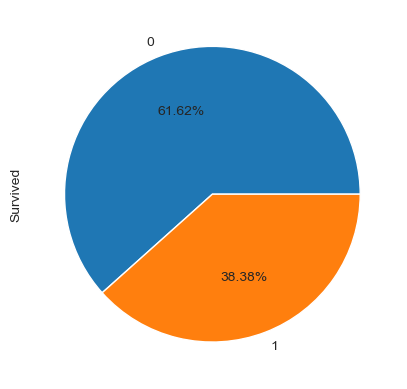

In [4]:
train_data['Survived'].value_counts().plot.pie(autopct="%1.2f%%")

In [5]:
# process missing values
'''
1）如果数据集很多，但有很少的缺失值，可以删掉带缺失值的行；
2）如果该属性相对学习来说不是很重要，可以对缺失值赋均值或者众数。比如在哪儿上船Embarked这一属性（共有三个上船地点），缺失俩值，可以用众数赋值
'''
train_data.Embarked[train_data.Embarked.isnull()] = train_data.Embarked.dropna().mode().values

In [6]:
'''
3) 对于标称属性，可以赋一个代表缺失的值，比如‘U0’。因为缺失本身也可能代表着一些隐含信息。比如船舱号Cabin这一属性，缺失可能代表并没有船舱。
'''
train_data['Cabin'] = train_data.Cabin.fillna("U0")

In [7]:
'''
4) 使用回归 随机森林等模型来预测缺失属性的值。因为Age在该数据集里是一个相当重要的特征（先对Age进行分析即可得知），所以保证一定的缺失值填充准确率是非常重要的，对结果也会产生较大影响。一般情况下，会使用数据完整的条目作为模型的训练集，以此来预测缺失值。对于当前的这个数据，可以使用随机森林来预测也可以使用线性回归预测。
'''
from sklearn.ensemble import RandomForestRegressor

#use one hot to encode features
age_data = train_data[['Age', 'Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']]
sex_one_hot = pd.get_dummies(age_data.Sex)
age_data = age_data.drop('Sex', axis=1).join(sex_one_hot)
embarked_one_hot = pd.get_dummies(age_data.Embarked)
age_data = age_data.drop('Embarked', axis=1).join(embarked_one_hot)
age_data.head()

# Split none null value
age_data_isnull = age_data.loc[(train_data.Age.isnull())]
age_data_notnull = age_data.loc[(train_data.Age.notnull())]

age_data_notnull.head()

,Age,Survived,Pclass,SibSp,Parch,Fare,female,male,C,Q,S
0,22.0,0,3,1,0,7.2500,0,1,0,0,1
1,38.0,1,1,1,0,71.2833,1,0,1,0,0
2,26.0,1,3,0,0,7.9250,1,0,0,0,1
3,35.0,1,1,1,0,53.1000,1,0,0,0,1
4,35.0,0,3,0,0,8.0500,0,1,0,0,1


In [8]:
# Make X,Y
X = age_data_notnull.values[:, 1:]
Y = age_data_notnull.values[:, 0]

# fit random forest
RFR = RandomForestRegressor(n_estimators=1000, n_jobs=1)
RFR.fit(X,Y)
predict = RFR.predict(age_data_isnull.values[:, 1:])
train_data.loc[(train_data['Age'].isnull()), ['Age']] = predict

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<AxesSubplot: xlabel='Sex'>

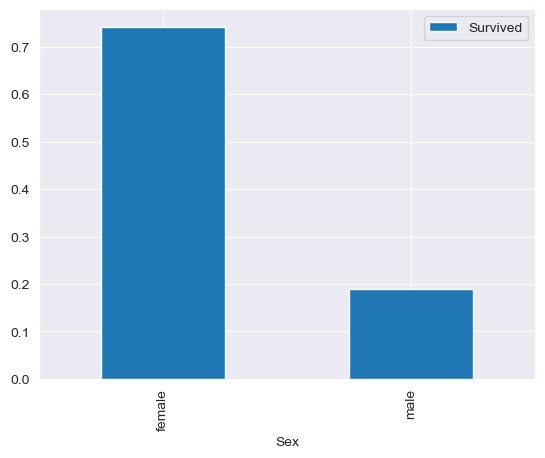

In [9]:
# check relationship between Sex and Survived
train_data.groupby(by=['Sex', 'Survived'])['Survived'].count()
train_data[['Sex', 'Survived']].groupby(by='Sex').mean().plot.bar()

<AxesSubplot: xlabel='Pclass'>

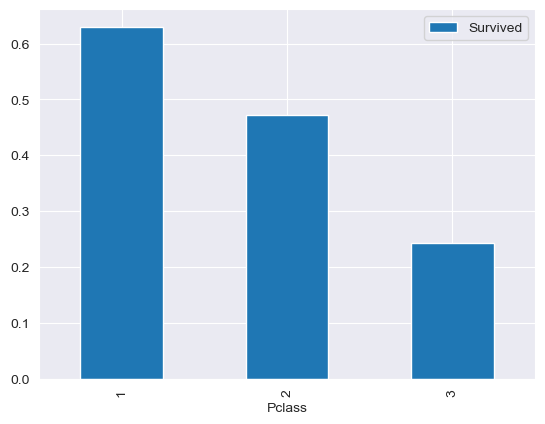

In [10]:
# Check relationship between Pclass and Survived
train_data[['Pclass', 'Survived']].groupby('Pclass').mean().plot.bar()

<AxesSubplot: xlabel='Pclass,Sex'>

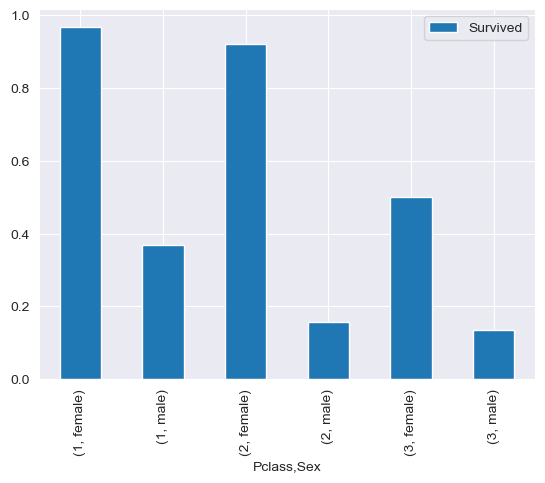

In [11]:
# Overview, that female has higher prob. although Pclass has slight effect as well
train_data[['Pclass', 'Sex', 'Survived']].groupby(['Pclass', 'Sex']).mean().plot.bar()

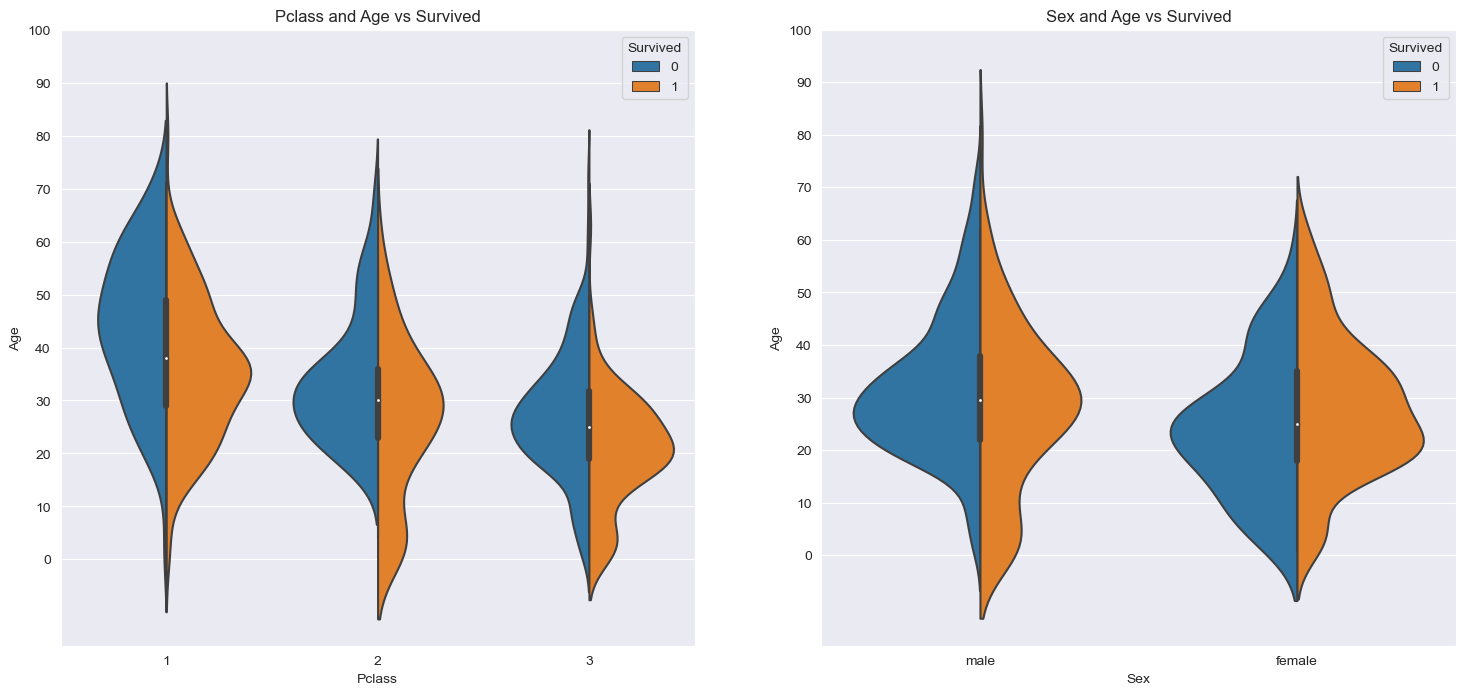

In [12]:
fig, ax = plt.subplots(1, 2, figsize = (18, 8))
sns.violinplot(x="Pclass", y="Age", hue="Survived", data=train_data, split=True, ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0, 110, 10))

sns.violinplot(x="Sex", y="Age", hue="Survived", data=train_data, split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0, 110, 10))

plt.show()

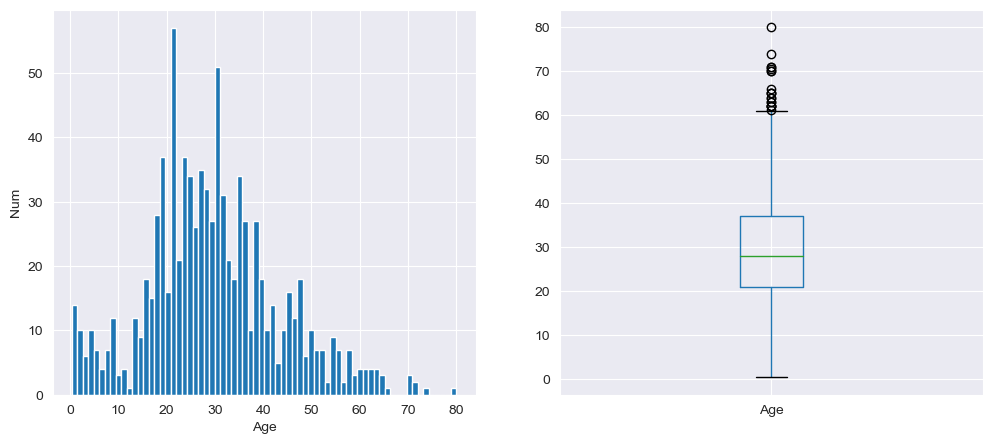

In [13]:
plt.figure(figsize=(12,5))
plt.subplot(121) # 示将图表分成1行2列，并使用第1个位置
train_data['Age'].hist(bins=70) #分成70个range
plt.xlabel('Age')
plt.ylabel('Num')

plt.subplot(122) #使用第二个位置
train_data.boxplot(column='Age') #绘制箱线图，不显示离群值
plt.show()

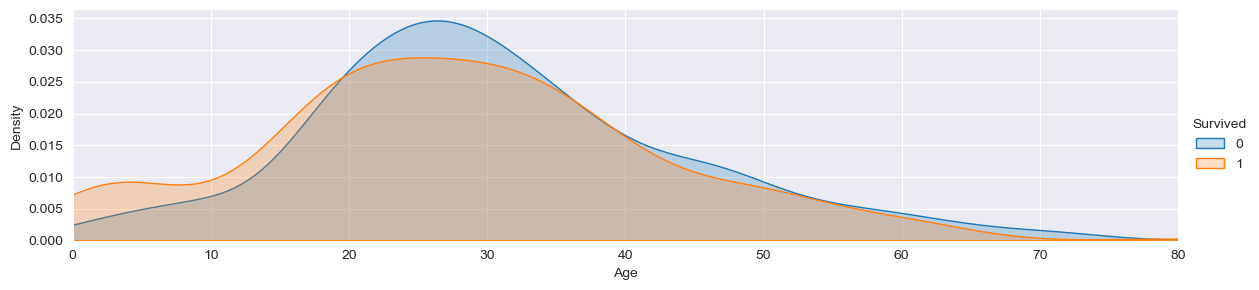

In [14]:
facet = sns.FacetGrid(train_data, hue="Survived",aspect=4) #创建多面版图，针对Survived进行分组，图的宽高比为4
facet.map(sns.kdeplot,'Age',shade= True) #将核密度图(KDE)应用到Age上，并对曲线下进行填充
facet.set(xlim=(0, train_data['Age'].max())) #设置x的最大最小值
facet.add_legend() # 添加图例

<AxesSubplot: xlabel='Age_int', ylabel='Survived'>

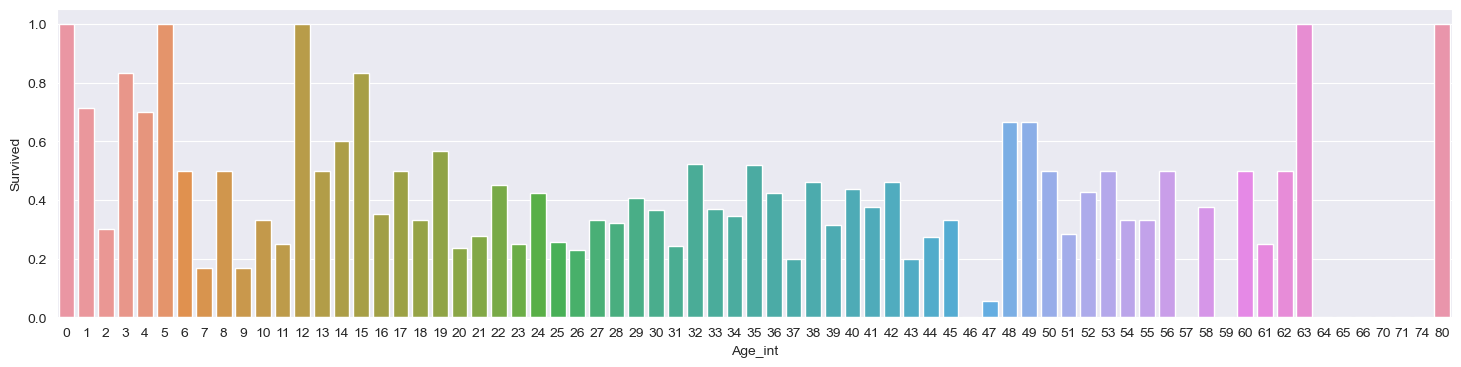

In [15]:
fig, axis1 = plt.subplots(1, 1, figsize=(18,4))
train_data["Age_int"] = train_data["Age"].astype(int)
average_age = train_data[["Age_int", "Survived"]].groupby("Age_int",as_index=False).mean() #不把Age_int当成索引而是作为特征
sns.barplot(x="Age_int", y = "Survived", data=average_age) #sns.barplot只能使用普通列而不是index列来作为x轴

In [16]:
train_data['Age'].describe()

count    891.000000
mean      29.642781
std       13.837935
min        0.420000
25%       21.000000
50%       28.000000
75%       37.000000
max       80.000000
Name: Age, dtype: float64

<AxesSubplot: xlabel='Age_group'>

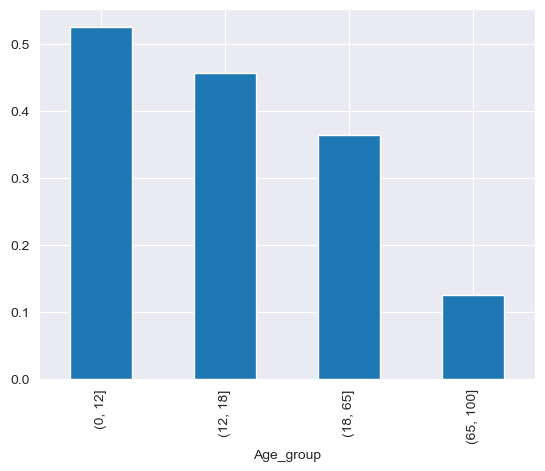

In [17]:
#Split the ages into groups
bins = [0, 12, 18, 65, 100]
train_data['Age_group'] = pd.cut(train_data['Age'], bins)
by_age = train_data.groupby('Age_group')['Survived'].mean()
by_age.plot.bar()

<AxesSubplot: xlabel='Title'>

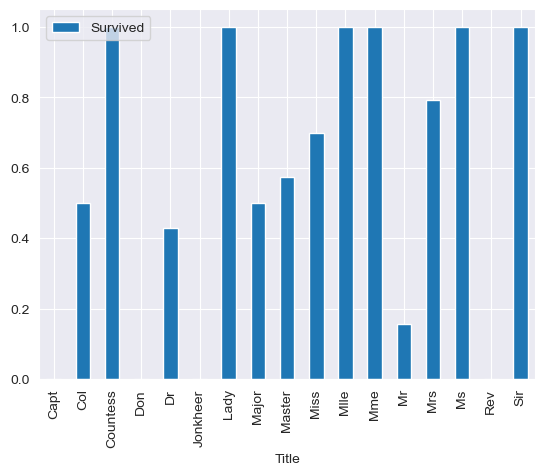

In [18]:
#Title with Survived
train_data["Title"] = train_data["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)
pd.crosstab(train_data['Title'], train_data['Survived'])
train_data[['Title', 'Survived']].groupby(['Title']).mean().plot.bar()

<AxesSubplot: xlabel='Name_length', ylabel='Survived'>

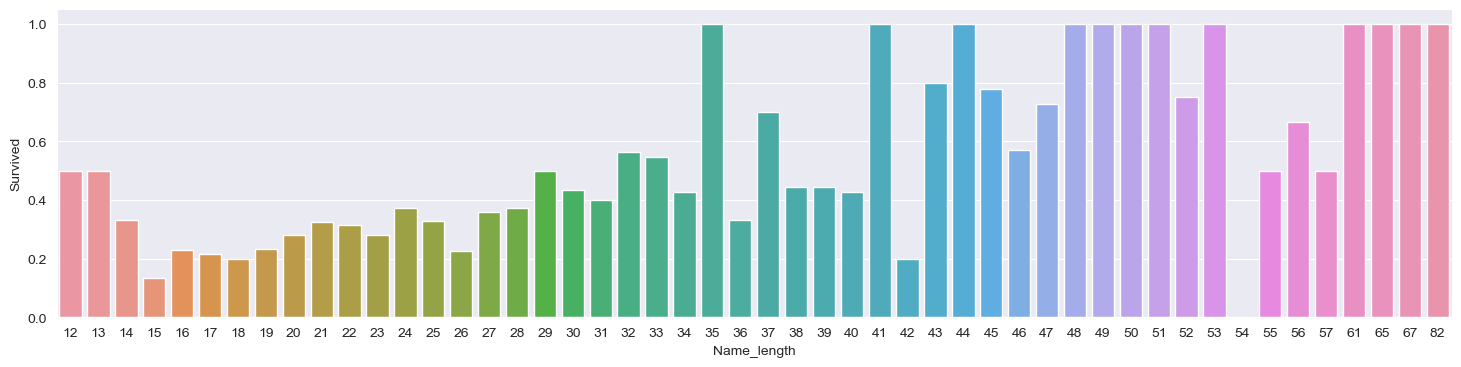

In [19]:
#Name length with survived
fig, axis1 = plt.subplots(1, 1, figsize=(18, 4))
train_data["Name_length"] = train_data["Name"].apply(len)
name_length = train_data[["Name_length", "Survived"]].groupby(["Name_length"], as_index=False).mean()
sns.barplot(x='Name_length', y='Survived', data=name_length)

In [20]:
#Have cousin or not
sibsp_data = train_data[train_data['SibSp'] != 0]
no_sibsp_data = train_data[train_data['SibSp'] == 0]
sibsp_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_int,Age_group,Title,Name_length
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U0,S,22,"(18, 65]",Mr,23
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,38,"(18, 65]",Mrs,51
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35,"(18, 65]",Mrs,44
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,U0,S,2,"(0, 12]",Master,30
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,U0,C,14,"(12, 18]",Mrs,35


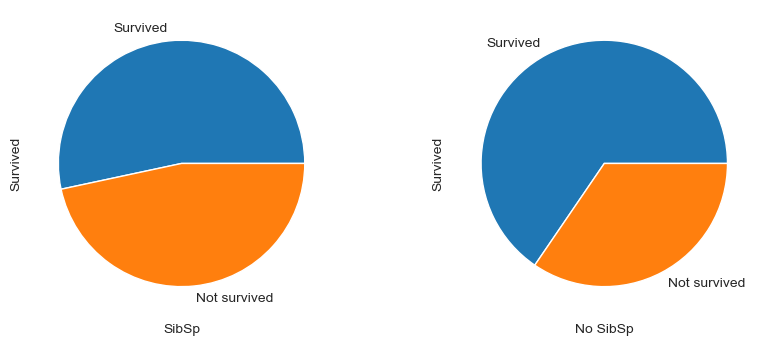

In [21]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sibsp_data['Survived'].value_counts().plot.pie(labels=['Survived', 'Not survived'])
plt.xlabel('SibSp')

plt.subplot(122)
no_sibsp_data['Survived'].value_counts().plot.pie(labels=['Survived', 'Not survived'])
plt.xlabel('No SibSp')

plt.show()

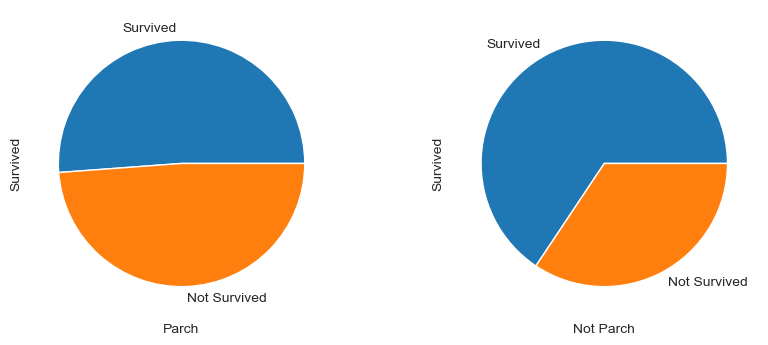

In [22]:
# Have parents or children
parch_data = train_data[train_data['Parch'] != 0]
no_parch_data = train_data[train_data['Parch'] == 0]

plt.figure(figsize=(10, 4))
plt.subplot(121)
parch_data['Survived'].value_counts().plot.pie(labels=['Survived', 'Not Survived'])
plt.xlabel('Parch')

plt.subplot(122)
no_parch_data['Survived'].value_counts().plot.pie(labels=['Survived', 'Not Survived'])
plt.xlabel('Not Parch')

plt.show()

Text(0.5, 1.0, 'Parch and Survived')

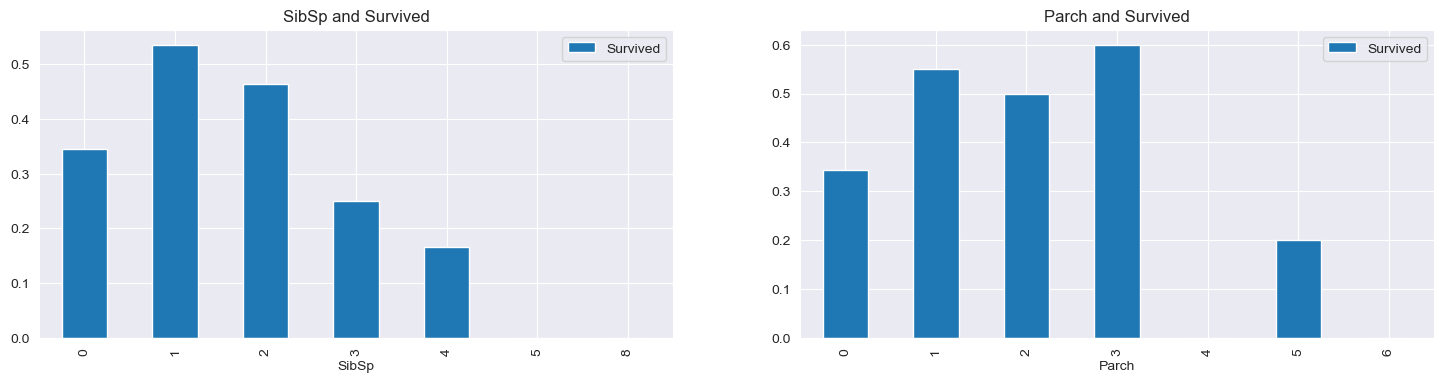

In [23]:
#no. of parch and SibSp with Survived
fig, ax = plt.subplots(1,2, figsize=(18,4))
train_data[['SibSp', 'Survived']].groupby('SibSp').mean().plot.bar(ax=ax[0])
ax[0].set_title('SibSp and Survived')

train_data[['Parch', 'Survived']].groupby('Parch').mean().plot.bar(ax = ax[1])
ax[1].set_title('Parch and Survived')

<AxesSubplot: xlabel='Family_Size'>

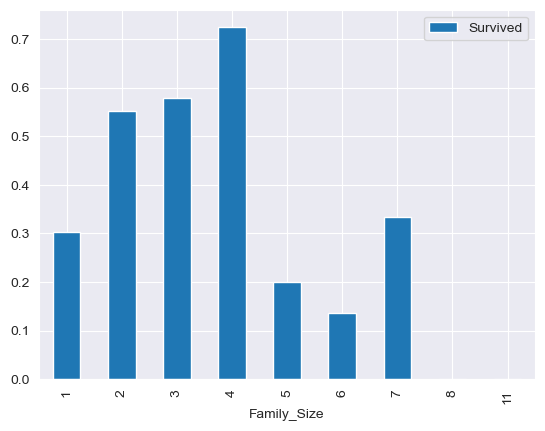

In [24]:
#Combine to family size
train_data['Family_Size'] = train_data['SibSp'] + train_data['Parch'] + 1
train_data[['Family_Size', 'Survived']].groupby('Family_Size').mean().plot.bar()

<AxesSubplot: >

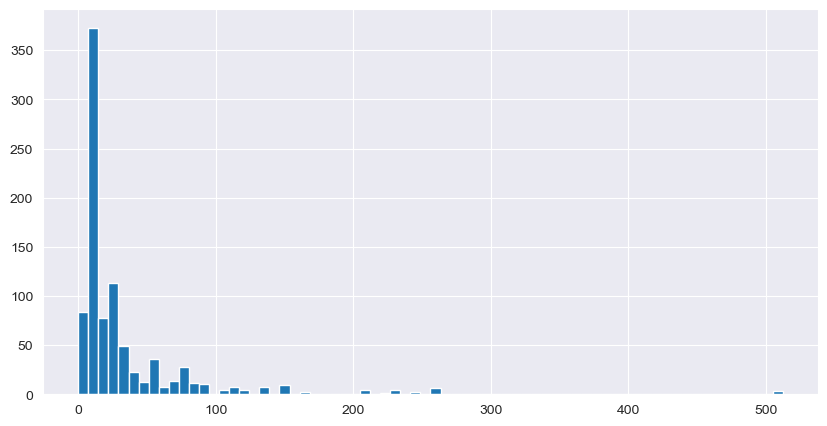

In [25]:
#Ticket prices distribution
plt.figure(figsize=(10,5))
train_data['Fare'].hist(bins=70)

<Figure size 1000x500 with 0 Axes>

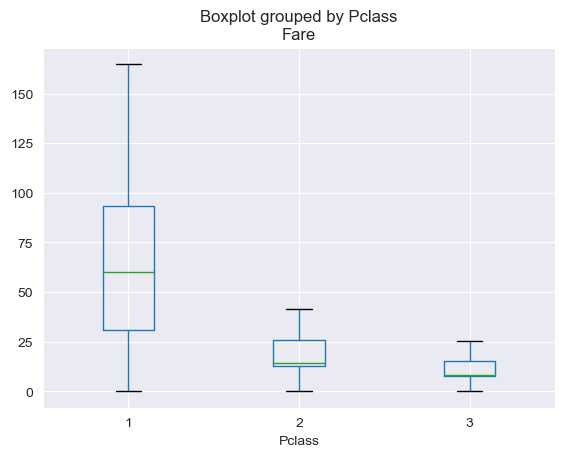

In [26]:
#Ticket price and pclass
plt.figure(figsize=(10, 5))
train_data.boxplot(column='Fare', by='Pclass', showfliers=False)
plt.show()

<AxesSubplot: >

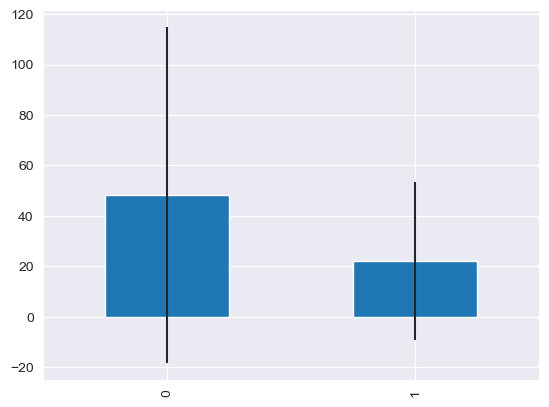

In [38]:
#ticket price with Survived
fare_survived = train_data['Fare'][train_data['Survived'] == 1]
fare_not_survived = train_data['Fare'][train_data['Survived'] == 0]

average_fare = pd.DataFrame([fare_survived.mean(), fare_not_survived.mean()])
std_fare = pd.DataFrame([fare_survived.std(), fare_not_survived.std()])
average_fare.plot.bar(yerr=std_fare, legend=False)